In [90]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.optimizers import SGD

import warnings
warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)


In [91]:
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download("AAPL", start, end)

[*********************100%***********************]  1 of 1 completed


In [92]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-14,24.330000,24.620001,24.187500,24.365000,22.497774,127727600
2016-06-15,24.455000,24.602501,24.257500,24.285000,22.423910,117780800
2016-06-16,24.112499,24.437500,24.017500,24.387501,22.518551,125307200
2016-06-17,24.155001,24.162500,23.825001,23.832500,22.006088,244032800
2016-06-20,24.000000,24.142500,23.757500,23.775000,21.952988,137647600
...,...,...,...,...,...,...
2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600
2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900
2023-06-09,181.500000,182.229996,180.630005,180.960007,180.960007,48870700


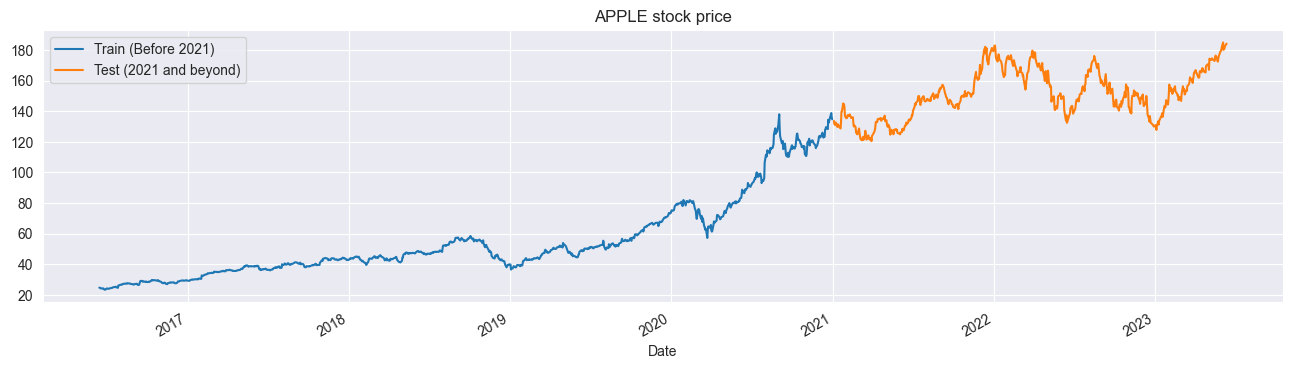

In [93]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("APPLE stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [94]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"]
    test = dataset.loc[f"{tend+1}":, "High"]
    return train, test

def train_test_split_values(dataset, tstart, tend):
    train, test =  train_test_split(dataset, tstart, tend)
    return train.values, test.values

training_set, test_set = train_test_split_values(dataset, tstart, tend)

In [95]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [96]:
def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)

In [97]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [98]:
dataset_total = dataset.loc[:, "High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - window_size:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [99]:
X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
y_test = sc.inverse_transform(y_test)

In [100]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

In [101]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(window_size, features)))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer="adam", loss="mse")

model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 125)               48000     
                                                                 
 dense_5 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


2023-06-14 12:21:33.881312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 12:21:33.882389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 12:21:33.883603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [102]:
model_gru.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


2023-06-14 12:21:34.140385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 12:21:34.141560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 12:21:34.143007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 [==============================] - 2s 18ms/step - loss: 0.0161
Epoch 2/10
34/34 [==============================] - 1s 18ms/step - loss: 5.5067e-04
Epoch 3/10
34/34 [==============================] - 1s 18ms/step - loss: 2.6516e-04
Epoch 4/10
34/34 [==============================] - 1s 18ms/step - loss: 2.6810e-04
Epoch 5/10
34/34 [==============================] - 1s 18ms/step - loss: 2.3398e-04
Epoch 6/10
34/34 [==============================] - 1s 18ms/step - loss: 2.2543e-04
Epoch 7/10
34/34 [==============================] - 1s 18ms/step - loss: 2.2942e-04
Epoch 8/10
34/34 [==============================] - 1s 18ms/step - loss: 2.2038e-04
Epoch 9/10
34/34 [==============================] - 1s 18ms/step - loss: 2.1048e-04
Epoch 10/10
34/34 [==============================] - 1s 18ms/step - loss: 2.0970e-04


In [103]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

10/20 [==============>...............] - ETA: 0s

2023-06-14 12:21:41.634574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 12:21:41.635551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 12:21:41.636948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 0s 6ms/step


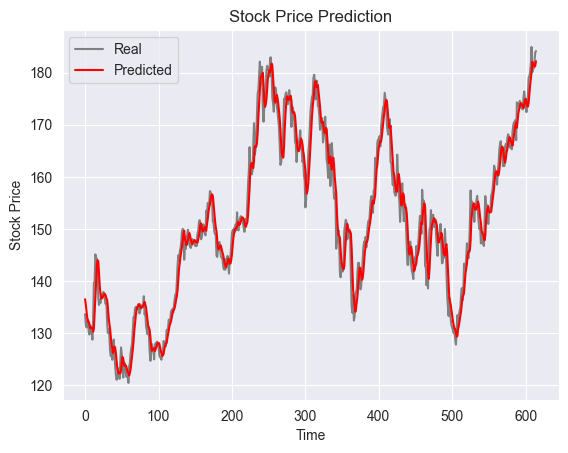

In [104]:
plot_predictions(y_test, GRU_predicted_stock_price)

In [105]:
return_rmse(y_test,GRU_predicted_stock_price)

The root mean squared error is 3.16.
